## Hybrid Sim V6

### Prerequisites

In [106]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
import ternary
import pandas as pd

In [68]:
# Set a random seed for reproducibility (if not required comment out line)

np.random.seed(32)
random.seed(32)

In [69]:
# Define constants
chromosome_length = 100 # Total number of positions (loci) on the chromosome 
MAGENTA = 'M'
YELLOW = 'Y'

### Recombination setup 

In [70]:
# Two recomb models, either uniform positions or varied at all positions.  
use_uniform_recomb = False  # Change to True to use constant recombination prob.

if use_uniform_recomb:
    recomb_probs = [0.1] * chromosome_length  # Same recombination probability across all positions
else:
    # U-shaped recombination: high at ends, low in middle
    positions = np.linspace(0, 1, chromosome_length)
    recomb_probs = [0.01 + 0.2 * (1 - np.exp(-((p - 0.5) ** 2) / 0.02)) for p in positions]

In [71]:
# Define the chance of a recombination event happening (0, 1, or 2 crossover events)
recomb_event_probs = [0.1, 0.85, 0.05]  # 10% no crossover, 85% one crossover, 5% two crossovers

### Parent generation

In [72]:
# Create MM and YY parent populations 
num_magenta = 100
num_yellow = 100

magenta_parents = [
    [[MAGENTA] * chromosome_length, [MAGENTA] * chromosome_length]
    for _ in range(num_magenta)
]

yellow_parents = [
    [[YELLOW] * chromosome_length, [YELLOW] * chromosome_length]
    for _ in range(num_yellow)
]

In [73]:
#Check first 5 parents 
print(magenta_parents[5])
print(yellow_parents[5])

[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '

### F1 generation

In [74]:
# Function to generate F1 pop from MM x YY
def generate_f1_population_from_parents(n, magenta_pool, yellow_pool):
    f1_population = []
    f1_parent_indices = []  # Store the (MM, YY) parent indices for each F1 individual

    for _ in range(n):
        mm_index = random.randint(0, len(magenta_pool) - 1)
        yy_index = random.randint(0, len(yellow_pool) - 1)

        mm_parent = magenta_pool[mm_index]
        yy_parent = yellow_pool[yy_index]

        chr1 = mm_parent[0]  # Take one chr from MM
        chr2 = yy_parent[1]  # Take one chr from YY

        f1_population.append([chr1.copy(), chr2.copy()])
        f1_parent_indices.append((mm_index, yy_index))  # Save parent indices

    return f1_population, f1_parent_indices

In [75]:
# Generate F1 population 
# This function selects one random MM parent and one random YY parent for each F1 individual to simulate a cross between them.
# Each resulting offspring has one chr from MM and one from YY.
f1_population, f1_parent_indices = generate_f1_population_from_parents(
    n=100, magenta_pool=magenta_parents, yellow_pool=yellow_parents
)

In [76]:
# Checkpoint 
# Inspect first F1 individual
f1_output_check = f1_population[0]
for i in range(5):  # Print first 5 loci
    print(f"Locus {i}: {f1_output_check[0][i]} / {f1_output_check[1][i]}")

Locus 0: M / Y
Locus 1: M / Y
Locus 2: M / Y
Locus 3: M / Y
Locus 4: M / Y


### F2 generation

In [77]:
def form_gamete_from_parent(parent, chromosome_length):
    # Decide how many recombination events to simulate
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probs, k=1)[0]

    # If 0 recombination → copy one entire strand
    if num_recombs == 0:
        return parent[random.choice([0, 1])][:]

    # Get crossover points, weighted by recombination probabilities
    crossover_points = sorted(
        random.choices(range(chromosome_length), weights=recomb_probs, k=num_recombs)
    )

    # Recombine between strands
    current_strand = random.choice([0, 1])
    gamete = []
    crossover_index = 0

    for i in range(chromosome_length):
        if crossover_index < len(crossover_points) and i == crossover_points[crossover_index]:
            current_strand = 1 - current_strand  # switch strand
            crossover_index += 1
        gamete.append(parent[current_strand][i])

    return gamete

In [78]:
def generate_f2_offspring(parent_a, parent_b, chromosome_length):
    gamete_1 = form_gamete_from_parent(parent_a, chromosome_length)
    gamete_2 = form_gamete_from_parent(parent_b, chromosome_length)
    return [gamete_1, gamete_2]

In [79]:
f2_population = []

# Randomly shuffle F1 indices and pair them up
f1_indices = np.random.permutation(len(f1_offspring))
pairs = list(zip(f1_indices[::2], f1_indices[1::2]))

for idx_a, idx_b in pairs:
    parent_a = f1_offspring[idx_a]
    parent_b = f1_offspring[idx_b]
    f2_individual = generate_f2_offspring(parent_a, parent_b, chromosome_length)
    f2_population.append(f2_individual)

#### Sanity Checks 

In [80]:
# Diagnostic check
print(f"Number of F2 individuals: {len(f2_population)}")

Number of F2 individuals: 50


In [81]:
# Check the first 3 F2 individuals
# Only shows the first 20 positions 
for i in range(3):
    ind = f2_population[i]
    print(f"\nF2 Individual {i+1}:")
    print(f"  Chromosome 1 alleles (first 20): {ind[0][:20]}")
    print(f"  Chromosome 2 alleles (first 20): {ind[1][:20]}")
    print(f"  Lengths: chr1 = {len(ind[0])}, chr2 = {len(ind[1])}")


F2 Individual 1:
  Chromosome 1 alleles (first 20): ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']
  Chromosome 2 alleles (first 20): ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
  Lengths: chr1 = 100, chr2 = 100

F2 Individual 2:
  Chromosome 1 alleles (first 20): ['M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
  Chromosome 2 alleles (first 20): ['M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
  Lengths: chr1 = 100, chr2 = 100

F2 Individual 3:
  Chromosome 1 alleles (first 20): ['Y', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']
  Chromosome 2 alleles (first 20): ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
  Lengths: chr1 = 100, chr2 = 100


In [82]:
mm_total, yy_total, my_total = 0, 0, 0

for ind in f2_population:
    for a1, a2 in zip(ind[0], ind[1]):
        pair = sorted([a1, a2])
        if pair == ['M', 'M']:
            mm_total += 1
        elif pair == ['Y', 'Y']:
            yy_total += 1
        else:
            my_total += 1

print("\nGenotype counts across all F2 individuals:")
print(f"  MM: {mm_total}")
print(f"  YY: {yy_total}")
print(f"  MY: {my_total}")


Genotype counts across all F2 individuals:
  MM: 1442
  YY: 1233
  MY: 2325


In [83]:
print("\nChecking for completely homozygous F2 individuals...")
for i, ind in enumerate(f2_population):
    homo_count = sum(1 for a1, a2 in zip(ind[0], ind[1]) if a1 == a2)
    if homo_count == chromosome_length:
        print(f"  WARNING: F2 individual {i} is fully homozygous!")


Checking for completely homozygous F2 individuals...


In [84]:
# Function to check recomb events 
def check_recombination_in_f2(f2_population):
    recomb_count = 0
    for idx, (chr1, chr2) in enumerate(f2_population):
        chr1_set = set(chr1)
        chr2_set = set(chr2)

        chr1_recombined = MAGENTA in chr1_set and YELLOW in chr1_set
        chr2_recombined = MAGENTA in chr2_set and YELLOW in chr2_set

        if chr1_recombined or chr2_recombined:
            recomb_count += 1

    print(f"{recomb_count} out of {len(f2_population)} F2 individuals have at least one recombined chromosome.")

In [85]:
check_recombination_in_f2(f2_population)

50 out of 50 F2 individuals have at least one recombined chromosome.


### Convert to genotype numerics and labels 

In [108]:
# Compute genotype numeric representation
# Lists to store data for the entire F2 population
f2_genotype_numeric_all = []    # List of lists (each individual's numeric genotypes)
f2_genotype_labels_all = []     # List of lists (each individual's genotype labels)

# Loop over each individual in the F2 population
for chr_1, chr_2 in f2_population:
    
    f2_genotype_numeric = []   # Genotype numeric for this individual
    f2_genotype_labels = []    # Genotype label for this individual

    # Loop through alleles at each position from both chromosomes
    for a, b in zip(chr_1, chr_2):
        pair = sorted([a, b])  # Sort to standardise MM, MY, etc.
        
        if pair == ['M', 'M']:
            f2_genotype_numeric.append(2)
            f2_genotype_labels.append('MM')
        elif pair == ['Y', 'Y']:
            f2_genotype_numeric.append(0)
            f2_genotype_labels.append('YY')
        else:
            f2_genotype_numeric.append(1)
            f2_genotype_labels.append(a + b)  # Keep orientation ('MY' or 'YM')

    # Append this individual's data to the population-level lists
    f2_genotype_numeric_all.append(f2_genotype_numeric)
    f2_genotype_labels_all.append(f2_genotype_labels)

In [87]:
# Check point 
# Only shows the first 10 locus 
for i in range(3):  # Show 3 example individuals
    print(f"Ind {i} genotypes (numeric): {f2_genotype_numeric_all[i][:10]}")
    print(f"Ind {i} genotypes (labels):  {f2_genotype_labels_all[i][:10]}")

Ind 0 genotypes (numeric): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ind 0 genotypes (labels):  ['MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY']
Ind 1 genotypes (numeric): [2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Ind 1 genotypes (labels):  ['MM', 'MM', 'MM', 'MM', 'MM', 'YY', 'YY', 'YY', 'YY', 'YY']
Ind 2 genotypes (numeric): [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ind 2 genotypes (labels):  ['YY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY']


### Hybrid Index and Het Calculation for Parent Gen and F1 

In [120]:
# Pick one MM parent at random from the magenta parent population
parent_mm_index = np.random.choice(len(magenta_parents), 1)[0]
parent_mm = magenta_parents[parent_mm_index]

# Pick one YY parent at random from the yellow parent population
parent_yy_index = np.random.choice(len(yellow_parents), 1)[0]
parent_yy = yellow_parents[parent_yy_index]

In [121]:
# Display the selected parents
print("Selected Magenta Parent (index {}):".format(parent_mm_index))
print(parent_mm)
print("\nSelected Yellow Parent (index {}):".format(parent_yy_index))
print(parent_yy)

Selected Magenta Parent (index 59):
[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 

In [122]:
# Pick one individual at random from the F1 population
f1_index = np.random.choice(len(f1_population), 1)[0]
f1_individual = f1_population[f1_index]

# Display the selected F1 individual
print("Selected F1 Individual (index {}):".format(f1_index))
print(f1_individual)

Selected F1 Individual (index 78):
[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', '

In [123]:
# 'M' = magenta, 'Y' = yellow
# MM = 2, MY/YM = 1, YY = 0

# Function to convert two chromosomes into numeric genotypes
def get_numeric_genotype(chr1, chr2):
    numeric = []
    for a, b in zip(chr1, chr2):
        pair = sorted([a, b])  # Account for 'MY' and 'YM' 
        if pair == ['M', 'M']:
            numeric.append(2)
        elif pair == ['M', 'Y']:  # This captures both 'MY' and 'YM'
            numeric.append(1)
        elif pair == ['Y', 'Y']:
            numeric.append(0)
        else:
            # Handle any unexpected allele combinations
            print(f"Warning: Unexpected allele pair: {a},{b}")
            numeric.append(None)
    return numeric

In [124]:
# Function to calculate HI and HET from numeric genotype
def calculate_hi_het(genotype_numeric):
    # Filter out any None values from the genotype list
    valid_genotypes = [g for g in genotype_numeric if g is not None]
    
    num_loci = len(valid_genotypes)
    if num_loci == 0:
        return 0, 0  # Avoid division by zero
    
    total_alleles = 2 * num_loci
    num_mm = valid_genotypes.count(2)
    num_yy = valid_genotypes.count(0)
    num_het = valid_genotypes.count(1)
    
    num_m_alleles = (2 * num_mm) + num_het
    hi = num_m_alleles / total_alleles
    het = num_het / num_loci
    
    return hi, het

In [125]:
# Calculate HI and HET for parents and F1 individual
# For the Magenta Parent
parent_mm_chr1, parent_mm_chr2 = parent_mm  # Assuming parent_mm contains two chromosomes
parent_mm_numeric = get_numeric_genotype(parent_mm_chr1, parent_mm_chr2)
parent_mm_hi, parent_mm_het = calculate_hi_het(parent_mm_numeric)

# For the Yellow Parent
parent_yy_chr1, parent_yy_chr2 = parent_yy  # Assuming parent_yy contains two chromosomes
parent_yy_numeric = get_numeric_genotype(parent_yy_chr1, parent_yy_chr2)
parent_yy_hi, parent_yy_het = calculate_hi_het(parent_yy_numeric)

# For the F1 Individual
f1_chr1, f1_chr2 = f1_individual  # Assuming F1_individual contains two chromosomes
f1_numeric = get_numeric_genotype(f1_chr1, f1_chr2)
f1_hi, f1_het = calculate_hi_het(f1_numeric)

In [ ]:
# Display the results
print("Magenta Parent:")
print(f"Hybrid Index: {parent_mm_hi:.3f}")
print(f"Heterozygosity: {parent_mm_het:.3f}")

print("\nYellow Parent:")
print(f"Hybrid Index: {parent_yy_hi:.3f}")
print(f"Heterozygosity: {parent_yy_het:.3f}")

print("\nF1 Individual:")
print(f"Hybrid Index: {f1_hi:.3f}")
print(f"Heterozygosity: {f1_het:.3f}")

### Hybrid Index Calculation F2

In [127]:
# Process the entire F2 population
f2_results = []
loci_data = []

# Iterate through each F2 individual
for i, f2_ind in enumerate(f2_population):
    # Assuming each individual is stored as a tuple/list with two chromosomes
    f2_chr1, f2_chr2 = f2_ind
    
    # Convert to numeric genotype
    f2_numeric = get_numeric_genotype(f2_chr1, f2_chr2)
    
    # Calculate hybrid index and heterozygosity
    hi, het = calculate_hi_het(f2_numeric)
    
    # Store main results
    f2_results.append({
        'Individual_ID': f'F2_{i+1}',
        'Hybrid_Index': hi,
        'Heterozygosity': het
    })
    
    # Store loci data separately
    loci_dict = {f'Locus_{j+1}': genotype for j, genotype in enumerate(f2_numeric)}
    loci_dict['Individual_ID'] = f'F2_{i+1}'  # Add ID for joining
    loci_data.append(loci_dict)

In [ ]:
# Create main DataFrame
f2_df = pd.DataFrame(f2_results)

# Create loci DataFrame
loci_df = pd.DataFrame(loci_data)

# Merge the two DataFrames
f2_complete_df = pd.merge(f2_df, loci_df, on='Individual_ID')

# Display the first few rows of the results
print(f2_complete_df.head())

In [ ]:
# Save a defragmented copy if needed
#f2_defrag_df = f2_complete_df.copy()

### Parent Gen Visual

In [134]:
# Visualise parents
# Colour map for alleles
color_map = {'M': 'deeppink', 'Y': 'gold'}

# Updated order: MM A, MM B, YY A, YY B
titles = ["MM Parent A", "MM Parent B", "YY Parent A", "YY Parent B"]

# Chromosome pairs per individual (same order as titles)
parent_chr_pairs = [
    (mm_parent_a[0], mm_parent_a[1]),
    (mm_parent_b[0], mm_parent_b[1]),
    (yy_parent_a[0], yy_parent_a[1]),
    (yy_parent_b[0], yy_parent_b[1])
]

# Dynamically scale figure width: 0.1 inch per locus per chromosome
fig_width = max(8, chromosome_length * 0.1)  # e.g., 100 loci → 10" width per chromosome
fig, axs = plt.subplots(1, 8, figsize=(fig_width, 4), sharey=True)

# Drawing settings
block_width = 0.6
block_height = 1
block_spacing = 1.2

# Loop through each individual and each chromosome
for i, (chr1, chr2) in enumerate(parent_chr_pairs):
    for j, chr in enumerate([chr1, chr2]):  # chr1 (0), chr2 (1)
        ax_index = i * 2 + j  # Convert to flat index (0 to 7)
        ax = axs[ax_index]
        for k, allele in enumerate(chr):
            y_pos = k * block_spacing
            ax.add_patch(
                mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele])
            )
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(chr) * block_spacing)
        ax.axis('off')

# Add individual titles centered above each pair of chromosomes
for i, title in enumerate(titles):
    mid_ax = axs[i * 2 + 0]
    mid_x = mid_ax.get_position().x0 + (axs[i * 2 + 1].get_position().x1 - mid_ax.get_position().x0) / 2
    fig.text(mid_x, 0.95, title, ha='center', va='bottom', fontsize=10)

# Add chromosome labels below each block
for i in range(4):  # For each parent
    axs[i * 2 + 0].text(0.5, -0.1, "chr 1", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 0].transAxes)
    axs[i * 2 + 1].text(0.5, -0.1, "chr 2", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 1].transAxes)

# Add legend
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[-1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.subplots_adjust(wspace=0.4)  # add spacing between the 8 subplots
plt.show()

NameError: name 'mm_parent_a' is not defined

### F1 Visual

In [ ]:
# Visualise F1 individuals
fig_height = max(6, chromosome_length * 0.12)  # 0.12" per locus, minimum 6"
fig, axs = plt.subplots(1, 4, figsize=(7, fig_height), sharey=True)

# Titles for each F1 individual
titles = ["F1 Individual A", "F1 Individual B"]

# Chromosome data grouped (chr1, chr2 per individual)
f1_chr_pairs = [
    (f1_a[0], f1_a[1]),
    (f1_b[0], f1_b[1])
]

# Drawing settings
block_width = 0.6
block_height = 1
block_spacing = 1.3

# Plot each chromosome in horizontal layout
for i, (chr1, chr2) in enumerate(f1_chr_pairs):
    for j, chr in enumerate([chr1, chr2]):  # chr1 then chr2
        ax_index = i * 2 + j
        ax = axs[ax_index]
        for k, allele in enumerate(chr):
            y_pos = k * block_spacing
            ax.add_patch(
                mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele])
            )
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(chr) * block_spacing)
        ax.axis('off')

# Add individual titles above their chromosome pair
for i, title in enumerate(titles):
    mid_ax = axs[i * 2]
    mid_x = mid_ax.get_position().x0 + (axs[i * 2 + 1].get_position().x1 - mid_ax.get_position().x0) / 2
    fig.text(mid_x, 0.95, title, ha='center', va='bottom', fontsize=10)

# Add chromosome labels just below blocks
for i in range(2):  # For each F1 individual
    axs[i * 2 + 0].text(0.5, -0.1, "chr 1", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 0].transAxes)
    axs[i * 2 + 1].text(0.5, -0.1, "chr 2", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 1].transAxes)

# Add legend on the right
axs[-1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.show()

In [317]:
# Function to get recombination points across F2 pop
def get_recomb_points(chrom_length, num_events, recomb_probs):
    
    # Only positions 1 to (chrom_length - 1) are valid recombination sites
    possible_positions = list(range(1, chrom_length))  # skip 0 (can't recombine before first locus)
    
    # Normalise probabilities over valid positions
    position_probs = np.array(recomb_probs[1:])  # slice from index 1 onward
    position_probs = position_probs / position_probs.sum()  # ensure it sums to 1
    
    # Sample recombination points without replacement, weighted by recomb_probs
    return sorted(np.random.choice(possible_positions, size=num_events, replace=False, p=position_probs))

### F2 Visual

In [ ]:
# Visualise F2 chromosome vertically
# Define colour for M and Y
color_map = {'M': 'deeppink', 'Y': 'gold'}

# Set block display properties
block_width = 0.6
block_height = 1
block_spacing = 1.08

# Create figure with 1 row and 4 vertical strip subplots
fig, axs = plt.subplots(1, 4, figsize=(9, 10), sharey=True)

# Titles for each vertical strip
titles = [
    "chr 1",
    "chr 2",
    "Genotype Numeric\n(2=MM, 1=MY/YM, 0=YY)",
    "Genotype Labels"
]

# Plot allele chr 1
for i, allele in enumerate(chr_1):
    y_pos = i * block_spacing
    axs[0].add_patch(mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele]))

# Plot allele chr 2
for i, allele in enumerate(chr_2):
    y_pos = i * block_spacing
    axs[1].add_patch(mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele]))

# Plot genotype numeric values
# Function to group consecutive identical items
def group_runs(data):
    runs = []
    start = 0
    for i in range(1, len(data)):
        if data[i] != data[start]:
            runs.append((start, i - 1, data[start]))
            start = i
    runs.append((start, len(data) - 1, data[start]))
    return runs

# Group numeric values
numeric_runs = group_runs(f2_chromosome)
for start, end, val in numeric_runs:
    y_start = start * block_spacing
    height = (end - start + 1) * block_spacing
    axs[2].add_patch(mpatches.Rectangle((0.1, y_start), block_width + 0.2, height, edgecolor='black', facecolor='white', fill=False))
    axs[2].text(0.5, y_start + height / 2 - 0.3, str(val), fontsize=10, ha='center')

# Plot genotype labels
# Function to group consecutive identical items
def group_runs(data):
    runs = []
    start = 0
    for i in range(1, len(data)):
        if data[i] != data[start]:
            runs.append((start, i - 1, data[start]))
            start = i
    runs.append((start, len(data) - 1, data[start]))
    return runs

# Clean label input (remove extra spaces, standardize)
clean_labels = [label.strip().upper() for label in f2_genotype_labels]

# Group identical label stretches
label_runs = group_runs(clean_labels)

# Plot merged genotype label blocks
for start, end, label in label_runs:
    y_start = start * block_spacing
    height = (end - start + 1) * block_spacing
    axs[3].add_patch(mpatches.Rectangle((0.1, y_start), block_width + 0.2, height,
                                        edgecolor='grey', facecolor='white', fill=False))
    axs[3].text(0.5, y_start + height / 2 - 0.3, label, fontsize=10, ha='center')

# Formatting
max_y = len(chr_1) * block_spacing
for ax, title in zip(axs, titles):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max_y)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Add legend to first column
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[0].legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(-1, 1), frameon=False)

plt.show()

In [ ]:
# Checkpoint - for verification purposes 

print("chr 1:", chr_1)
print("chr 2:", chr_2)
print("F2 Chromosome Genotype:", f2_chromosome)

### Triangle Plot

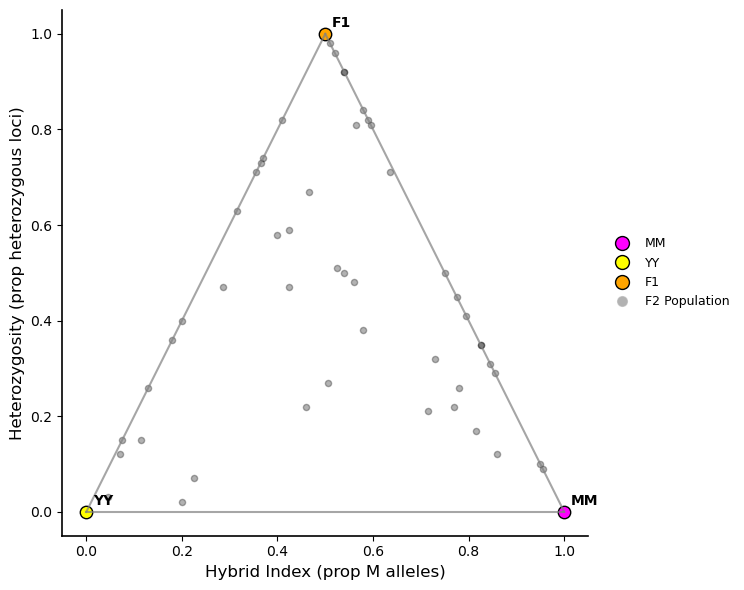

In [133]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Remove only top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Label axes
ax.set_xlabel("Hybrid Index (prop M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (prop heterozygous loci)", fontsize=12)

# Plot all F2 individuals as semi-transparent black dots
ax.scatter(
    f2_complete_df['Hybrid_Index'],
    f2_complete_df['Heterozygosity'],
    color='black',
    alpha=0.3,
    s=20,
    label='F2 Population'
)

# Plot the actual parent and F1 values we calculated earlier
ax.scatter(
    parent_mm_hi, parent_mm_het,
    color='magenta', s=80, edgecolor='black', label='MM'
)
ax.scatter(
    parent_yy_hi, parent_yy_het, 
    color='yellow', s=80, edgecolor='black', label='YY'
)
ax.scatter(
    f1_hi, f1_het,
    color='orange', s=80, edgecolor='black', label='F1'
)

# Add annotations for key points
ax.annotate('MM', (parent_mm_hi, parent_mm_het), 
            xytext=(5, 5), textcoords='offset points', 
            fontsize=10, fontweight='bold')
ax.annotate('YY', (parent_yy_hi, parent_yy_het), 
            xytext=(5, 5), textcoords='offset points', 
            fontsize=10, fontweight='bold')
ax.annotate('F1', (f1_hi, f1_het), 
            xytext=(5, 5), textcoords='offset points', 
            fontsize=10, fontweight='bold')

# Draw the triangle edges
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)],  # YY to F1
    [(0.5, 1.0), (1.0, 0.0)],  # F1 to MM
    [(0.0, 0.0), (1.0, 0.0)]   # YY to MM (base of triangle)
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Set axis limits
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='MM'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='YY'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population')
]

ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=9
)

# Layout adjustment
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()